# Learning to Sample a Distribution (1D)

Goal:
- Define a simple 1D target distribution p(x)
- Train a neural network that maps noise → samples
- Compare true distribution and learned samples

Key idea:
We do NOT predict x.
We learn a transformation z ~ N(0,1) → x ~ p(x).


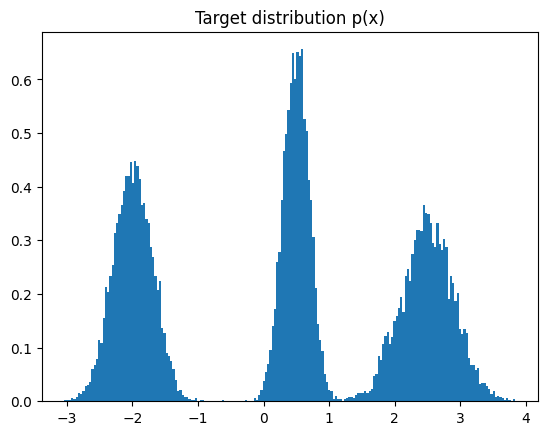

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

# Target distribution: mixture of Gaussians
def sample_target(n):
    comp = torch.randint(0, 3, (n,))
    means = torch.tensor([-2.0, 0.5, 2.5])
    stds  = torch.tensor([0.3, 0.2, 0.4])
    x = torch.randn(n) * stds[comp] + means[comp]
    return x.unsqueeze(1)

# Draw reference samples
x_ref = sample_target(20_000).numpy()

plt.hist(x_ref, bins=200, density=True)
plt.title("Target distribution p(x)")
plt.savefig("1_distribution.png")
plt.show()

In [2]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, z):
        return self.net(z)

G = Generator()


In [3]:
def sliced_wasserstein_1d(x_fake, x_real):
    x_fake_sorted, _ = torch.sort(x_fake.view(-1))
    x_real_sorted, _ = torch.sort(x_real.view(-1))
    return torch.mean((x_fake_sorted - x_real_sorted) ** 2)

In [4]:
optimizer = torch.optim.Adam(G.parameters(), lr=1e-3)

for epoch in range(3001):
    z = torch.randn(4096, 1)
    x_fake = G(z)

    x_real = sample_target(4096)

    loss = sliced_wasserstein_1d(x_fake, x_real)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch:4d} | loss = {loss.item():.6f}")


Epoch    0 | loss = 3.381860
Epoch  300 | loss = 0.070677
Epoch  600 | loss = 0.043956
Epoch  900 | loss = 0.020114
Epoch 1200 | loss = 0.028750
Epoch 1500 | loss = 0.016013
Epoch 1800 | loss = 0.014389
Epoch 2100 | loss = 0.060386
Epoch 2400 | loss = 0.014534
Epoch 2700 | loss = 0.032120
Epoch 3000 | loss = 0.019527


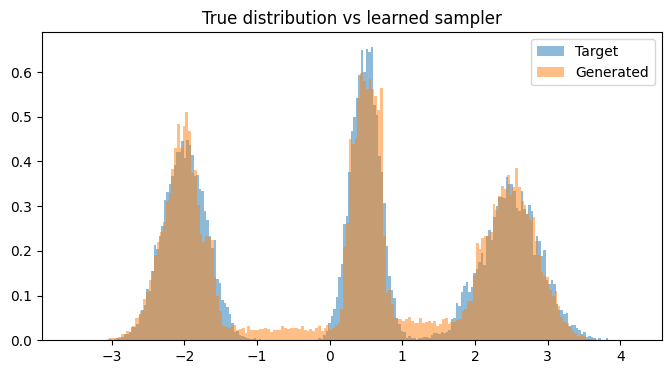

In [6]:
with torch.no_grad():
    z = torch.randn(50_000, 1)
    x_gen = G(z).numpy()

plt.figure(figsize=(8,4))
plt.hist(x_ref, bins=200, density=True, alpha=0.5, label="Target")
plt.hist(x_gen, bins=200, density=True, alpha=0.5, label="Generated")
plt.legend()
plt.title("True distribution vs learned sampler")
plt.savefig("1_sampling.png")
plt.show()


## What we learned

- Sampling ≠ regression
- The network never sees "correct x for given z"
- It only learns to transform noise into the right *distribution*

This is the conceptual foundation of:
- GANs
- Normalizing flows
- Diffusion models (next step)
